### Pyspark initialization 

In [1]:
#import spark
import argparse
import os
import numpy as np
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
import builtins
from cmath import nan
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 ass2 BNPL group 28")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/10/15 20:43:52 WARN Utils: Your hostname, Rudyletsgo resolves to a loopback address: 127.0.1.1; using 172.31.44.254 instead (on interface eth0)
22/10/15 20:43:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/10/15 20:43:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/15 20:43:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/15 20:43:54 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/10/15 20:43:54 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/10/15 20:43:54 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


### Read data 

In [2]:
merchants = spark.read.parquet('../data/tables/tbl_merchants.parquet')
consumers = spark.read.parquet('../data/tables/consumer_user_details.parquet')
transactions1 = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot')
transactions2 = spark.read.parquet('../data/tables/transactions_20210828_20220227_snapshot')
transactions3 = spark.read.parquet('../data/tables/transactions_20220228_20220828_snapshot')
consumers_csv = spark.read.options(header='True', inferSchema='True', delimiter='|').csv('../data/tables/tbl_consumer.csv')

In [3]:
consumers_csv = consumers_csv.withColumnRenamed("name", "user_name")
merchants = merchants.withColumnRenamed("name", "merchant_name")
transactions = transactions1.unionByName(transactions2)
transactions = transactions.unionByName(transactions3)

In [4]:
curated_csv = transactions.join(consumers, transactions.user_id == consumers.user_id, "leftouter").drop(consumers.user_id)
curated_csv = curated_csv.join(merchants, curated_csv.merchant_abn == merchants.merchant_abn, "leftouter").drop(merchants.merchant_abn)
curated_csv = curated_csv.join(consumers_csv, curated_csv.consumer_id == consumers_csv.consumer_id, "leftouter").drop(consumers_csv.consumer_id)

In [5]:
curated_csv = curated_csv.withColumn('tags', expr("substring(tags, 3, length(tags)-4)")) \
    .withColumn('field', split(col("tags"), "\], \[|\), \(").getItem(0)) \
        .withColumn('revenue_level', split(col("tags"), "\], \[|\), \(").getItem(1)) \
            .withColumn('take_rate', split(col("tags"), "\], \[|\), \(").getItem(2)) \
                .withColumn('take_rate', regexp_extract(col("take_rate"), r'(\d+).(\d+)', 0)) \
                    .withColumn("take_rate", col('take_rate').cast(FloatType())) \
                        .withColumn('field', lower(col('field'))) \
                            .withColumn('revenue_level', lower(col('revenue_level'))) \
                                .drop("tags")

### General understanding of dataset

In [6]:
curated_csv.limit(5)
print(curated_csv.count(),len(curated_csv.columns))

14195505 15


In [7]:
curated_csv.columns

['user_id',
 'merchant_abn',
 'dollar_value',
 'order_id',
 'order_datetime',
 'consumer_id',
 'merchant_name',
 'user_name',
 'address',
 'state',
 'postcode',
 'gender',
 'field',
 'revenue_level',
 'take_rate']

In [8]:
#from pyspark.sql.functions import col,isnan, when, count
#curated_csv.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in curated_csv.columns]
   #).show()

### Remove unused columns

In [9]:
cols = ['address','gender']
#curated_csv2 = curated_csv.drop(curated_csv.address)
curated_csv = curated_csv.drop(*cols)
#curated_csv4 = curated_csv3.drop(curated_csv.user_name)
print(curated_csv.count(),len(curated_csv.columns))

14195505 13


### Outlier analysis

In [10]:
# check null value
curated_csv = curated_csv.dropna()
print(curated_csv.count(),len(curated_csv.columns))

[15.329s][warning][gc,alloc] Executor task launch worker for task 13.0 in stage 24.0 (TID 848): Retried waiting for GCLocker too often allocating 262146 words
[15.333s][warning][gc,alloc] Executor task launch worker for task 19.0 in stage 24.0 (TID 854): Retried waiting for GCLocker too often allocating 262146 words


22/10/15 20:44:07 WARN TaskMemoryManager: Failed to allocate a page (2097152 bytes), try again.
22/10/15 20:44:07 WARN TaskMemoryManager: Failed to allocate a page (2097152 bytes), try again.


13614675 13


Check there are no duplicate order

In [11]:
curated_csv.limit(5)

user_id,merchant_abn,dollar_value,order_id,order_datetime,consumer_id,merchant_name,user_name,state,postcode,field,revenue_level,take_rate
5630,60956456424,145.26081329000152,1e14adeb-8e13-44f...,2021-08-21,28242,Ultricies Digniss...,Philip Crawford,NT,841,"gift, card, novel...",b,4.69
5630,89726005175,84.28725731295376,69a7c169-3cee-44d...,2022-07-03,28242,Est Nunc Consulting,Philip Crawford,NT,841,tent and awning s...,a,6.01
5630,48534649627,120.25889985200416,08476339-f383-4ab...,2021-08-15,28242,Dignissim Maecena...,Philip Crawford,NT,841,"opticians, optica...",a,6.64
5630,49322182190,76.46296684433246,ba9f0996-294f-42d...,2022-04-16,28242,Gravida Mauris In...,Philip Crawford,NT,841,"watch, clock, and...",a,6.35
5630,60956456424,135.5412540082104,aacfd47a-438b-47f...,2021-08-15,28242,Ultricies Digniss...,Philip Crawford,NT,841,"gift, card, novel...",b,4.69


In [12]:
# check wrong data
from os import curdir
from pyspark.sql import functions as F
new_data = curated_csv.filter(
    (F.col('user_id') > 0 )
    & (F.col('dollar_value') >= 0)
    & (F.col('consumer_id') > 0)
    & (F.col('postcode') > 0)
)
print(new_data.count(),len(new_data.columns))

13614675 13


In [13]:
new_data.limit(5)

user_id,merchant_abn,dollar_value,order_id,order_datetime,consumer_id,merchant_name,user_name,state,postcode,field,revenue_level,take_rate
5630,60956456424,145.26081329000152,1e14adeb-8e13-44f...,2021-08-21,28242,Ultricies Digniss...,Philip Crawford,NT,841,"gift, card, novel...",b,4.69
5630,48534649627,120.25889985200416,08476339-f383-4ab...,2021-08-15,28242,Dignissim Maecena...,Philip Crawford,NT,841,"opticians, optica...",a,6.64
5630,60956456424,135.5412540082104,aacfd47a-438b-47f...,2021-08-15,28242,Ultricies Digniss...,Philip Crawford,NT,841,"gift, card, novel...",b,4.69
5630,89932674734,95.37693966478514,6d5790c9-0eef-453...,2021-08-16,28242,Nulla Vulputate C...,Philip Crawford,NT,841,artist supply and...,c,1.67
5630,14089706307,440.12097711482835,43d1361a-1101-41a...,2021-08-16,28242,Donec Institute,Philip Crawford,NT,841,computer programm...,b,3.33


Feature (state) check

In [14]:
# this is the count of state, no need to filter
new_data.groupBy(new_data['state']).count()

22/10/15 20:45:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:45:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:45:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:45:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:45:29 WARN TaskMemoryManager: Failed to allocate a page (2097152 bytes), try again.
22/10/15 20:45:29 WARN TaskMemoryManager: Failed to allocate a page (1048576 bytes), try again.
22/10/15 20:45:29 WARN TaskMemoryManager: Failed to allocate a page (1048576 bytes), try again.
22/10/15 20:45:29 WARN TaskMemoryManager: Failed to allocate a page (1048576 bytes), try again.
22/10/15 20:45:29 WARN TaskMemoryManager: Failed to allocate a page (2097152 bytes), try again.
22/10/15 20:45:29 WARN TaskMemoryManager: Failed to 

[97.783s][warning][gc,alloc] Executor task launch worker for task 18.0 in stage 60.0 (TID 2485): Retried waiting for GCLocker too often allocating 262146 words
[97.786s][warning][gc,alloc] Executor task launch worker for task 4.0 in stage 60.0 (TID 2471): Retried waiting for GCLocker too often allocating 131074 words
[97.798s][warning][gc,alloc] Executor task launch worker for task 10.0 in stage 60.0 (TID 2477): Retried waiting for GCLocker too often allocating 131074 words
[97.801s][warning][gc,alloc] Executor task launch worker for task 1.0 in stage 60.0 (TID 2468): Retried waiting for GCLocker too often allocating 131074 words
[97.803s][warning][gc,alloc] Executor task launch worker for task 18.0 in stage 60.0 (TID 2485): Retried waiting for GCLocker too often allocating 262146 words
[97.809s][warning][gc,alloc] Executor task launch worker for task 0.0 in stage 60.0 (TID 2467): Retried waiting for GCLocker too often allocating 262146 words
[97.809s][warning][gc,alloc] Executor task 

22/10/15 20:45:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:45:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:45:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:45:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:45:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:45:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:45:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:45:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:45:31 WARN RowBasedKeyValueBatch: Calling spill() on

state,count
NT,193967
ACT,124972
SA,1547006
TAS,504569
WA,2155279
QLD,2014613
VIC,3146464
NSW,3927805


In [15]:
merchants.head(5)

[Row(merchant_name='Felis Limited', tags='((furniture, home furnishings and equipment shops, and manufacturers, except appliances), (e), (take rate: 0.18))', merchant_abn=10023283211),
 Row(merchant_name='Arcu Ac Orci Corporation', tags='([cable, satellite, and otHer pay television and radio services], [b], [take rate: 4.22])', merchant_abn=10142254217),
 Row(merchant_name='Nunc Sed Company', tags='([jewelry, watch, clock, and silverware shops], [b], [take rate: 4.40])', merchant_abn=10165489824),
 Row(merchant_name='Ultricies Dignissim Lacus Foundation', tags='([wAtch, clock, and jewelry repair shops], [b], [take rate: 3.29])', merchant_abn=10187291046),
 Row(merchant_name='Enim Condimentum PC', tags='([music shops - musical instruments, pianos, and sheet music], [a], [take rate: 6.33])', merchant_abn=10192359162)]

Feature(revenue_level) check

In [16]:
# count of different revenue level, no need to filter
new_data.groupBy(new_data['revenue_level']).count()

22/10/15 20:46:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:46:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:46:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:46:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:46:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:46:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:46:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:46:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/15 20:46:03 WARN RowBasedKeyValueBatch: Calling spill() on

revenue_level,count
e,120108
d,136838
c,3324800
b,3921368
a,6111561


Feature(take_rate) check

In [17]:
new_data.select('take_rate').describe()

summary,take_rate
count,13614675
mean,4.588886960094146
stddev,1.7384891948563417
min,0.1
max,7.0


In [18]:
# check dollar
import matplotlib.pyplot as plt
# check outliers
a = new_data.sample(0.5).select('take_rate')

In [19]:
a = a.toPandas()


[196.060s][warning][gc,alloc] Executor task launch worker for task 7.0 in stage 155.0 (TID 4631): Retried waiting for GCLocker too often allocating 262146 words


22/10/15 20:47:08 WARN TaskMemoryManager: Failed to allocate a page (2097152 bytes), try again.


In [20]:
a['take_rate']=a['take_rate'].astype(float)

<AxesSubplot:>

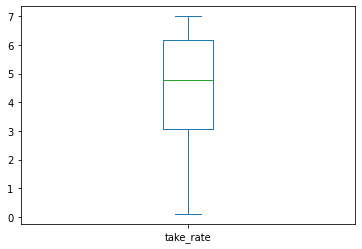

In [21]:
a.plot.box()

Feature(date) check, remove the transactions are not in selected time range

In [22]:
# check the order datetime
from pyspark.sql import functions as F
new_df = new_data.filter(
    (F.col('order_datetime') >= '2021-02-28') 
    & (F.col('order_datetime') <= '2022-08-28')
)

print(new_df.count(),len(new_df.columns))

12047317 13


In [23]:
new_df.select('postcode').describe()
#new_df.limit(5)

summary,postcode
count,12047317
mean,4043.344625778503
stddev,1780.6993191675244
min,200
max,9999


In [24]:
# check postcode
new_df = new_df.withColumn("length_of_str",F.length('postcode'))
new_df.select('length_of_str').describe()
new_df = new_df.filter(
    (F.col('length_of_str') <= 4)
    & (F.col('length_of_str') >=3)
)
new_df = new_df.drop('length_of_str')
print(new_df.count(),len(new_df.columns))

12047317 13


In [25]:
new_df.select('postcode').describe()

summary,postcode
count,12047317
mean,4043.344625778503
stddev,1780.6993191675244
min,200
max,9999


In [26]:
# check postcode
new_df = new_df.withColumn("length_of_str",F.length('postcode'))
new_df.select('length_of_str').describe()
new_df = new_df.filter(
    (F.col('length_of_str') == 4)
    #&(F.col('length_of_str') >=3 )
)
new_df = new_df.drop('length_of_str')
print(new_df.count(),len(new_df.columns))

11873781 13


In [27]:
new_df.select('postcode').describe()

summary,postcode
count,11873781
mean,4090.160012720464
stddev,1750.713307080176
min,1001
max,9999
